# SVM

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
import gensim.downloader as api

In [2]:
MAX_TEXT_LENGTH = 20
SUM_DISTRIBUTION = 256
INTER_DIM =31
HIDDEN_DIM_1 = [64, 32, 16]
HIDDEN_DIM_2 = [512, 256, 128, 128, 64, 32, 16, 16, 32, 64, 32]
LABEL_NUM = 5
BATCH_SIZE_2 = 8
EPOCH_2 = 100
LEARNING_RATE_2 = 0.001
TRAIN_PATH_2 = "../data/text/prompt_train.csv"
VALID_PATH_2 = "../data/text/prompt_valid.csv"
TEST_PATH_2 = "../data/text/prompt_test.csv"
SAVE_MODEL_PATH_1 = "../model/best_classifier.pth"
SAVE_MODEL_PATH_2 = "../model/best_generator.pth"

Data loaders created successfully.


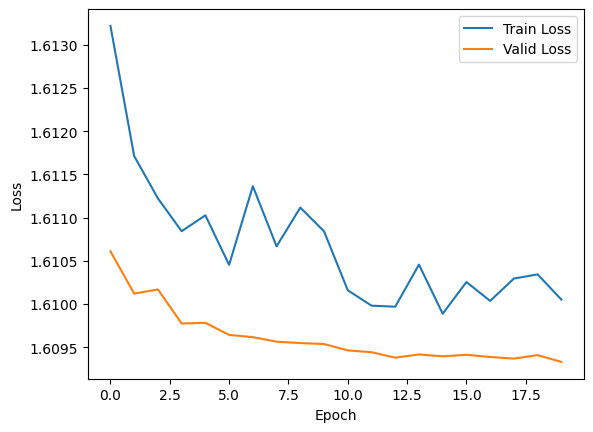

Accuracy: 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.20      1.00      0.33        10

    accuracy                           0.20        50
   macro avg       0.04      0.20      0.07        50
weighted avg       0.04      0.20      0.07        50



C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

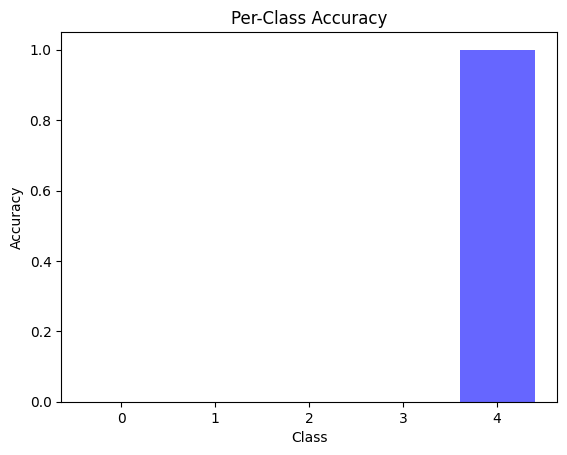

In [3]:
train_df = pd.read_csv(TRAIN_PATH_2)
valid_df = pd.read_csv(VALID_PATH_2)
test_df = pd.read_csv(TEST_PATH_2)

# # # TF-IDF
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(train_df.iloc[:, 0])
# X_valid_tfidf = vectorizer.transform(valid_df.iloc[:, 0])
# X_test_tfidf = vectorizer.transform(test_df.iloc[:, 0])
# y_train = train_df.iloc[:, 1].values
# y_valid = valid_df.iloc[:, 1].values
# y_test = test_df.iloc[:, 1].values
# X_train = torch.FloatTensor(X_train_tfidf.toarray())
# X_valid = torch.FloatTensor(X_valid_tfidf.toarray())
# X_test = torch.FloatTensor(X_test_tfidf.toarray())
# y_train = torch.LongTensor(y_train)
# y_valid = torch.LongTensor(y_valid)
# y_test = torch.LongTensor(y_test)


# # Word2Vec
word2vec_model = api.load("word2vec-google-news-300")
# Function to convert a sentence to a Word2Vec vector
def sentence_to_word2vec(sentence, model):
    words = sentence.split()
    word_vectors = [model[word] for word in words if word in model]
    if len(word_vectors) == 0:
        return np.zeros(300)  # Assuming Word2Vec vectors are 300-dimensional
    return np.mean(word_vectors, axis=0)
# Convert text data to Word2Vec vectors
X_train_word2vec = np.array([sentence_to_word2vec(sentence, word2vec_model) for sentence in train_df.iloc[:, 0]])
X_valid_word2vec = np.array([sentence_to_word2vec(sentence, word2vec_model) for sentence in valid_df.iloc[:, 0]])
X_test_word2vec = np.array([sentence_to_word2vec(sentence, word2vec_model) for sentence in test_df.iloc[:, 0]])
y_train = train_df.iloc[:, 1].values
y_valid = valid_df.iloc[:, 1].values
y_test = test_df.iloc[:, 1].values
# Convert Word2Vec vectors to tensors
X_train = torch.FloatTensor(X_train_word2vec)
X_valid = torch.FloatTensor(X_valid_word2vec)
X_test = torch.FloatTensor(X_test_word2vec)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)
y_test = torch.LongTensor(y_test)

# Construct Dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE_2, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=BATCH_SIZE_2)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE_2)

INPUT_DIM = X_train.shape[1]

print("Data loaders created successfully.")


import torch
import torch.nn as nn
import torch.nn.functional as F

class RBFKernel(nn.Module):
    def __init__(self, input_dim, output_dim, gamma=None):
        super(RBFKernel, self).__init__()
        self.gamma = gamma or 1.0 / input_dim
        self.centers = nn.Parameter(torch.randn(output_dim, input_dim))
        self.weights = nn.Parameter(torch.randn(output_dim))

    def forward(self, x):
        size = (x.size(0), self.centers.size(0), self.centers.size(1))
        expanded_x = x.unsqueeze(1).expand(size)
        distances = torch.sum((expanded_x - self.centers) ** 2, 2)
        features = torch.exp(-self.gamma * distances)  # RBF Kernel
        return torch.matmul(features, self.weights)

class SVMLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SVMLayer, self).__init__()
        self.kernel = RBFKernel(input_dim, output_dim)

    def forward(self, x):
        return self.kernel(x)



class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(nn.ReLU())
        
        # Add the final layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


def transform_to_fixed_sum(probabilities, n_dims=31, total_sum=256):
    transformed = np.zeros((probabilities.shape[0], n_dims), dtype=int)
    for i, vector in enumerate(probabilities):
        indices = np.argsort(-vector)[:n_dims]
        transformed[i, indices] = vector[indices] * total_sum // vector[indices].sum()
        remaining = total_sum - transformed[i].sum()
        if remaining > 0:
            transformed[i, indices[0]] += remaining
    return transformed


# class IntegratedClassifier(nn.Module):
#     def __init__(self, input_dim, pretrained_classifier):
#         super(IntegratedClassifier, self).__init__()
#         self.svm_layer = SVMLayer(input_dim,1)
#         self.linear = nn.Linear(1, 31)  # 将SVM输出映射到31维
#         self.pretrained_classifier = pretrained_classifier
    
#     def forward(self, x):
#         svm_output = self.svm_layer(x)
#         svm_output_transformed = self.linear(svm_output.unsqueeze(1))
#         return self.pretrained_classifier(svm_output_transformed)

class IntegratedClassifier(nn.Module):
    def __init__(self, input_dim, pretrained_classifier):
        super(IntegratedClassifier, self).__init__()
        self.svm_layer = SVMLayer(input_dim, 31)
        self.mlp = MLPClassifier(1, [16], 31)  # Assume output_dim is also 31 for MLP
        self.pretrained_classifier = pretrained_classifier

    def forward(self, x):
        svm_output = self.svm_layer(x)
        mlp_output = self.mlp(svm_output) 
        return self.pretrained_classifier(mlp_output.unsqueeze(0))

input_dim = X_train.shape[1]
pretrained_classifier = MLPClassifier(INTER_DIM, HIDDEN_DIM_1, LABEL_NUM)
pretrained_classifier.load_state_dict(torch.load(SAVE_MODEL_PATH_1))
integrated_classifier = IntegratedClassifier(input_dim, pretrained_classifier)
integrated_classifier.pretrained_classifier.requires_grad_(False)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(integrated_classifier.parameters(), lr=0.001)


best_valid_loss = float('inf')
best_model = None
train_losses, valid_losses = [], []

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=1, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=1)

for epoch in range(20):
    integrated_classifier.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = integrated_classifier(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_losses.append(epoch_train_loss / len(train_loader))
    
    integrated_classifier.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = integrated_classifier(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_valid_loss += loss.item()
        
        valid_losses.append(epoch_valid_loss / len(valid_loader))
        
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            best_model = integrated_classifier.state_dict()

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


integrated_classifier.load_state_dict(best_model)


test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1)
integrated_classifier.eval()
all_preds = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = integrated_classifier(X_batch)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_test, all_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, all_preds))


class_correct = [0] * 5
class_total = [0] * 5
for i in range(len(y_test)):
    label = y_test[i]
    class_correct[label] += (all_preds[i] == label)
    class_total[label] += 1

class_accuracy = [c / t for c, t in zip(class_correct, class_total)]


plt.bar(range(5), class_accuracy, color='blue', alpha=0.6, label='Correct')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.show()